In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split

from models import MobileNetV3

from data_preparation import CreateDataset,\
                             load_images_and_labels, \
                             encode_labels, \
                             create_data_augmentation

from trainer import train_model, \
                    plot_losses, \
                    evaluate_model

import boto3
import multiprocessing

num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
BATCH_SIZE = 32

In [4]:
data = "ck"
bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [5]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [6]:
# label_encoder, y_train, y_test = encode_labels(y_train, y_test)
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)


In [7]:
transform = create_data_augmentation()

In [8]:
train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [10]:
model = MobileNetV3(num_labels=len(label_encoder.classes_))
model.to(device)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [11]:
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = CrossEntropyLoss()

best_model, train_losses, val_losses = train_model(
                                    model=model,
                                    train_loader=train_loader,
                                    val_loader=val_loader,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    device=device,
                                    epochs=500,
                                    patience=10
                                )

100%|██████████| 16/16 [00:02<00:00,  5.76it/s]


Epoch 1, Train Loss: 1.8249, Validation Loss: 1.8843


100%|██████████| 16/16 [00:02<00:00,  6.93it/s]


Epoch 2, Train Loss: 1.5809, Validation Loss: 1.7585


100%|██████████| 16/16 [00:02<00:00,  7.13it/s]


Epoch 3, Train Loss: 1.3627, Validation Loss: 1.5591


100%|██████████| 16/16 [00:02<00:00,  7.15it/s]


Epoch 4, Train Loss: 1.1533, Validation Loss: 1.3951


100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 5, Train Loss: 0.9788, Validation Loss: 1.3001


100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Epoch 6, Train Loss: 0.8229, Validation Loss: 1.2331


100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 7, Train Loss: 0.6945, Validation Loss: 1.2316


100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 8, Train Loss: 0.5786, Validation Loss: 1.1700


100%|██████████| 16/16 [00:02<00:00,  7.12it/s]


Epoch 9, Train Loss: 0.4907, Validation Loss: 1.2508


100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 10, Train Loss: 0.4068, Validation Loss: 1.3316


100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Epoch 11, Train Loss: 0.3634, Validation Loss: 1.3297


100%|██████████| 16/16 [00:02<00:00,  6.96it/s]


Epoch 12, Train Loss: 0.3007, Validation Loss: 1.1759


100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 13, Train Loss: 0.2567, Validation Loss: 1.2624


100%|██████████| 16/16 [00:02<00:00,  6.77it/s]


Epoch 14, Train Loss: 0.2220, Validation Loss: 1.0630


100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 15, Train Loss: 0.1815, Validation Loss: 1.0223


100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 16, Train Loss: 0.1584, Validation Loss: 0.9647


100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 17, Train Loss: 0.1341, Validation Loss: 0.8671


100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 18, Train Loss: 0.1148, Validation Loss: 0.8359


100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 19, Train Loss: 0.1027, Validation Loss: 0.7889


100%|██████████| 16/16 [00:02<00:00,  6.88it/s]


Epoch 20, Train Loss: 0.0795, Validation Loss: 0.8642


100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 21, Train Loss: 0.0708, Validation Loss: 0.8469


100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 22, Train Loss: 0.0621, Validation Loss: 0.7720


100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Epoch 23, Train Loss: 0.0526, Validation Loss: 0.7487


100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 24, Train Loss: 0.0454, Validation Loss: 0.7463


100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 25, Train Loss: 0.0517, Validation Loss: 0.7237


100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 26, Train Loss: 0.0417, Validation Loss: 0.7403


100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 27, Train Loss: 0.0411, Validation Loss: 0.5734


100%|██████████| 16/16 [00:02<00:00,  7.15it/s]


Epoch 28, Train Loss: 0.0321, Validation Loss: 0.7782


100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 29, Train Loss: 0.0357, Validation Loss: 0.7146


100%|██████████| 16/16 [00:02<00:00,  7.08it/s]


Epoch 30, Train Loss: 0.0246, Validation Loss: 0.6225


100%|██████████| 16/16 [00:02<00:00,  6.98it/s]


Epoch 31, Train Loss: 0.0308, Validation Loss: 0.6504


100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 32, Train Loss: 0.0257, Validation Loss: 0.7128


100%|██████████| 16/16 [00:02<00:00,  6.97it/s]


Epoch 33, Train Loss: 0.0193, Validation Loss: 0.5630


100%|██████████| 16/16 [00:02<00:00,  6.99it/s]


Epoch 34, Train Loss: 0.0180, Validation Loss: 0.5859


100%|██████████| 16/16 [00:02<00:00,  7.01it/s]


Epoch 35, Train Loss: 0.0191, Validation Loss: 0.3042


100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 36, Train Loss: 0.0166, Validation Loss: 0.4098


100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 37, Train Loss: 0.0201, Validation Loss: 0.3215


100%|██████████| 16/16 [00:02<00:00,  6.94it/s]


Epoch 38, Train Loss: 0.0220, Validation Loss: 0.2941


100%|██████████| 16/16 [00:02<00:00,  6.92it/s]


Epoch 39, Train Loss: 0.0162, Validation Loss: 0.2469


100%|██████████| 16/16 [00:02<00:00,  6.80it/s]


Epoch 40, Train Loss: 0.0111, Validation Loss: 0.2459


100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 41, Train Loss: 0.0091, Validation Loss: 0.2053


100%|██████████| 16/16 [00:02<00:00,  6.83it/s]


Epoch 42, Train Loss: 0.0104, Validation Loss: 0.2116


100%|██████████| 16/16 [00:02<00:00,  6.86it/s]


Epoch 43, Train Loss: 0.0186, Validation Loss: 0.1452


100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 44, Train Loss: 0.0118, Validation Loss: 0.1912


100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


Epoch 45, Train Loss: 0.0113, Validation Loss: 0.2207


100%|██████████| 16/16 [00:02<00:00,  7.05it/s]


Epoch 46, Train Loss: 0.0104, Validation Loss: 0.1828


100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Epoch 47, Train Loss: 0.0074, Validation Loss: 0.1648


100%|██████████| 16/16 [00:02<00:00,  6.95it/s]


Epoch 48, Train Loss: 0.0066, Validation Loss: 0.1478


100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 49, Train Loss: 0.0065, Validation Loss: 0.1154


100%|██████████| 16/16 [00:02<00:00,  7.06it/s]


Epoch 50, Train Loss: 0.0067, Validation Loss: 0.1506


100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


Epoch 51, Train Loss: 0.0095, Validation Loss: 0.1549


100%|██████████| 16/16 [00:02<00:00,  6.87it/s]


Epoch 52, Train Loss: 0.0098, Validation Loss: 0.1258


100%|██████████| 16/16 [00:02<00:00,  7.03it/s]


Epoch 53, Train Loss: 0.0104, Validation Loss: 0.1604


100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Epoch 54, Train Loss: 0.0074, Validation Loss: 0.1837


100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Epoch 55, Train Loss: 0.0086, Validation Loss: 0.1930


100%|██████████| 16/16 [00:02<00:00,  6.90it/s]


Epoch 56, Train Loss: 0.0127, Validation Loss: 0.1694


100%|██████████| 16/16 [00:02<00:00,  7.07it/s]


Epoch 57, Train Loss: 0.0060, Validation Loss: 0.1392


100%|██████████| 16/16 [00:02<00:00,  7.01it/s]


Epoch 58, Train Loss: 0.0080, Validation Loss: 0.2007


100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


Epoch 59, Train Loss: 0.0085, Validation Loss: 0.2101
Early stopping triggered


In [12]:
# Save the model to a local path
model_dir = f'{data}/models'

model_path = f'mobilenetv3_{data}_best_model.pt'
torch.save(model.state_dict(), model_path)

# Upload the model to S3
s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

os.remove(model_path)

In [13]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

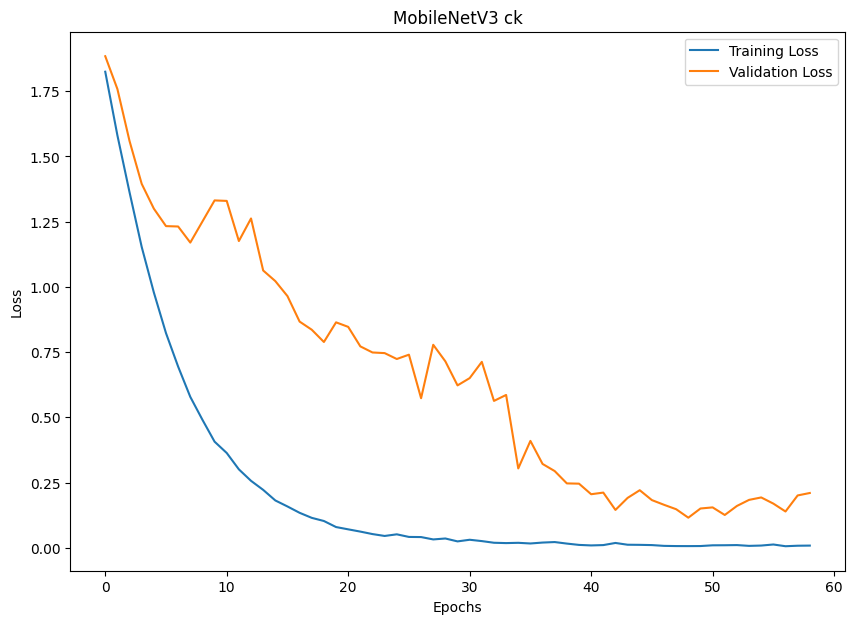

In [14]:
plot_losses(train_losses, val_losses, title=f"MobileNetV3 {data}")

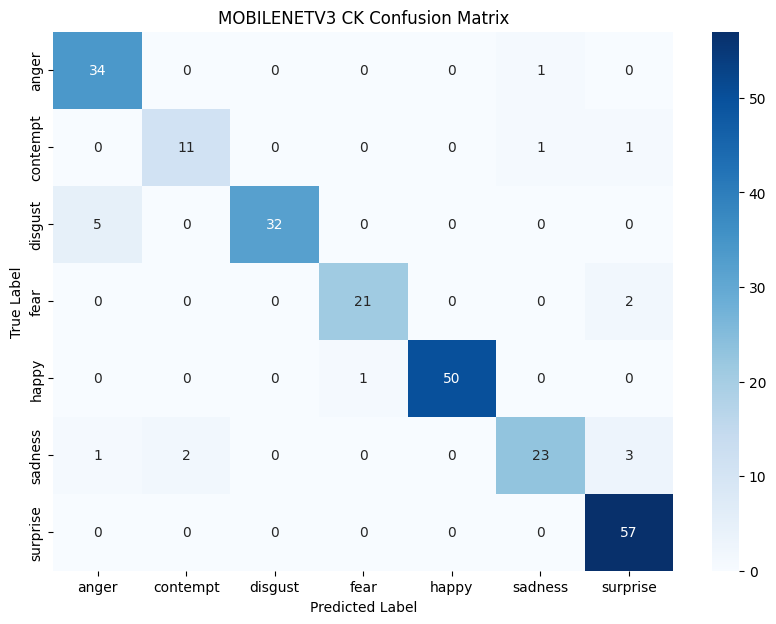

Test Accuracy: 0.9306
Precision: 0.9251
Recall: 0.9099
F1 Score: 0.9151
Classification Report:
               precision    recall  f1-score   support

       anger       0.85      0.97      0.91        35
    contempt       0.85      0.85      0.85        13
     disgust       1.00      0.86      0.93        37
        fear       0.95      0.91      0.93        23
       happy       1.00      0.98      0.99        51
     sadness       0.92      0.79      0.85        29
    surprise       0.90      1.00      0.95        57

    accuracy                           0.93       245
   macro avg       0.93      0.91      0.92       245
weighted avg       0.93      0.93      0.93       245



In [15]:
evaluate_model(model=model,
               test_loader=test_loader,
               device=device,
               data="MobileNetV3 CK",
               label_encoder=label_encoder)